# *In situ* data preparation

In [94]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import rasterio
from rasterio import features
import rasterio.plot
import plotly.express as px
from IPython.display import display

print('All libraries successfully imported!')
print(f'Pandas    : {pd.__version__}')
print(f'GeoPandas : {gpd.__version__}')

All libraries successfully imported!
Pandas    : 1.1.5
GeoPandas : 0.9.0


## Set directory

In [4]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'

clipped_path = f'{work_path}2_L2A_CLIPPED/'
in_situ_path = f'{work_path}IN_SITU/'

## Set parameters

In [57]:
site = 'NAMUR'
year = '2020'

field_classif_code = 'sub_nb'
field_classif_name = 'sub'
buffer_size   = -10
pix_min       = 3
pix_ratio_min = 0.0002
poly_min      = 5

## 1. Apply 10m buffer to each polygons

In [7]:
in_situ_file = f'{in_situ_path}{site}_{year}_IN_SITU_ROI.shp'

gdf = gpd.read_file(in_situ_file)

print(f'The Coordinates Reference System is {gdf.crs} \n')

print(f'There are {len(gdf)} polygons BEFORE applying the {buffer_size}m buffer.')

gdf.geometry = gdf.geometry.buffer(buffer_size)

gdf = gdf[~gdf.geometry.is_empty]    # Remove empty geometries

print(f'There are {len(gdf)} polygons AFTER applying the {buffer_size}m buffer.')

display(gdf.head())


The Coordinates Reference System is epsg:32631 

There are 733 polygons BEFORE applying the -10m buffer.
There are 629 polygons AFTER applying the -10m buffer.


,id,sub_nb,sub,grp_nb,grp,class_nb,class,lc_nb,lc,geometry
0,0,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"MULTIPOLYGON (((636113.254 5595481.323, 636113..."
1,1,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((629775.101 5593157.573, 629778.482 5..."
2,2,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((636748.981 5595728.374, 636750.028 5..."
3,3,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"MULTIPOLYGON (((630003.573 5594258.004, 630003..."
4,4,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((636962.589 5595674.757, 636966.536 5..."


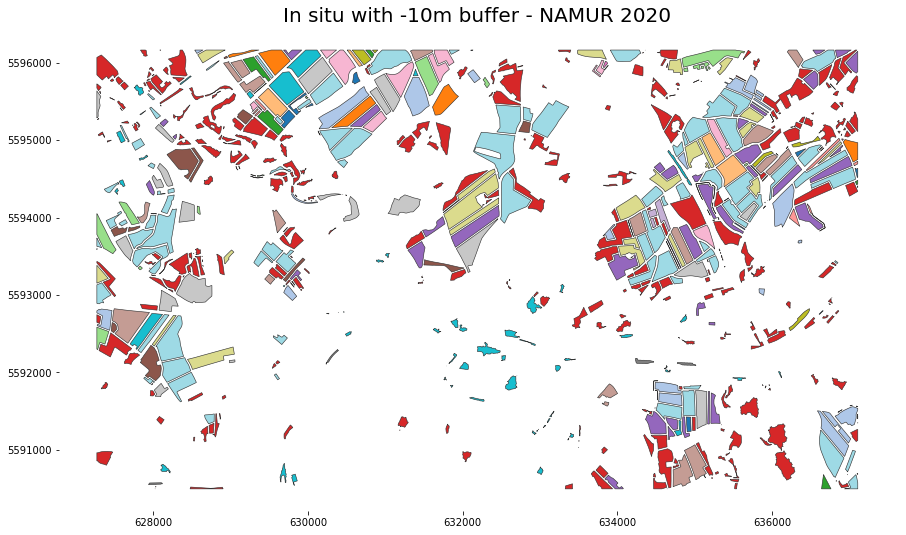

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

gdf.plot(ax=ax,
        column='sub',
        categorical=True,
        cmap='tab20',
        linewidth=.6,
        edgecolor='0.2',
        legend=False)

ax.set_title(f'In situ with {buffer_size}m buffer - {site} {year}',fontsize=20)

plt.box(False)

## 2. Add area column

In [10]:
gdf['area'] = gdf.geometry.area.astype(int)

display(gdf.head())

,id,sub_nb,sub,grp_nb,grp,class_nb,class,lc_nb,lc,geometry,area
0,0,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"MULTIPOLYGON (((636113.254 5595481.323, 636113...",0
1,1,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((629775.101 5593157.573, 629778.482 5...",235
2,2,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((636748.981 5595728.374, 636750.028 5...",251
3,3,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"MULTIPOLYGON (((630003.573 5594258.004, 630003...",1735
4,4,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((636962.589 5595674.757, 636966.536 5...",14331


## 3. Add pixel count

### 3.1 Select one raster clipped to the extent of the ROI as a template to rasterize *in situ* polygons

In [12]:
img_temp_tif = glob.glob(f'{clipped_path}*.tif')[0]

print(f'Raster template file : {img_temp_tif}')

Raster template file : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/2_L2A_CLIPPED/T31UFS_20200417T104021_SCL_10m_ROI.tif


### 3.2 Rasterize *in situ* polygons

In [14]:
in_situ_file_tif = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_buffer.tif'

# Open the raster file you want to use as a template for rasterize

src = rasterio.open(img_temp_tif, "r")

# Update metadata

out_meta = src.meta
out_meta.update(dtype='int16',
                nodata=-999)

# Burn the features into the raster and write it out

dst = rasterio.open(in_situ_file_tif, 'w+', **out_meta)
dst_arr = dst.read(1)

# this is where we create a generator of geom, value pairs to use in rasterizing

geom_col = gdf.geometry
code_col = gdf['id'].astype(int)

shapes = ((geom,value) for geom, value in zip(geom_col, code_col))

in_situ_arr = features.rasterize(shapes=shapes,
                                 fill=-999,
                                 out=dst_arr,
                                 transform=dst.transform,
                                 all_touched=False)

dst.write_band(1, in_situ_arr)

# Close rasterio objects
src.close()
dst.close()

print(f'Rasterize is done : {in_situ_file_tif}')

Rasterize is done : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/IN_SITU/NAMUR_2020_IN_SITU_ROI_buffer.tif


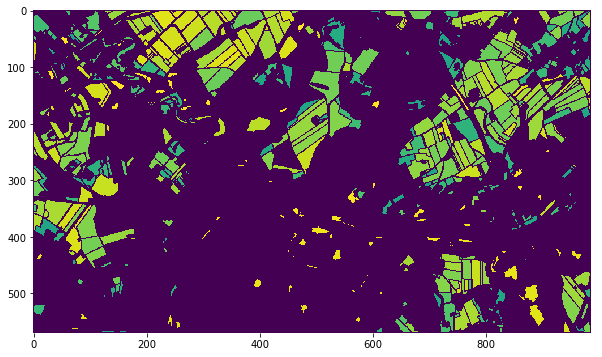

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

rasterio.plot.show(in_situ_arr, ax=ax)

plt.box(False)

### 3.3 Count number of pixels for each polygons

In [17]:
unique, counts = np.unique(in_situ_arr, return_counts=True)
pix_count_df = pd.DataFrame(zip(unique, counts), columns=['id','pix_count'], dtype='int16')

display(pix_count_df)

,id,pix_count
0,-999,-12677
1,1,2
2,3,17
3,4,146
4,5,18
...,...,...
600,728,77
601,729,23
602,730,82
603,731,47


### 3.4 Merge pixels count with polygons informations

In [18]:
pix_count_gdf = gdf.merge(pix_count_df, on='id', how="left")

display(pix_count_gdf.head())

print(f'There are {len(pix_count_gdf)} polygons')

,id,sub_nb,sub,grp_nb,grp,class_nb,class,lc_nb,lc,geometry,area,pix_count
0,0,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"MULTIPOLYGON (((636113.254 5595481.323, 636113...",0,NaN
1,1,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((629775.101 5593157.573, 629778.482 5...",235,2.0
2,2,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((636748.981 5595728.374, 636750.028 5...",251,NaN
3,3,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"MULTIPOLYGON (((630003.573 5594258.004, 630003...",1735,17.0
4,4,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((636962.589 5595674.757, 636966.536 5...",14331,146.0


There are 629 polygons


## 4. Remove unnecessary *in situ* polygons

### 4.1 Remove polygons with less than `pix_min` pixels

In [89]:
gdf = pix_count_gdf.loc[pix_count_gdf['pix_count'] >= pix_min]

gdf = gdf.astype({"pix_count": int})

print(f'There are {len(gdf)} polygons with more (or equal) than {pix_min} pixels.')

There are 583 polygons with more (or equal) than 3 pixels.


### 4.2 Remove polygons from under represented and unwanted classes

**Under represented** classes mean the classes with :
- not enough pixels - less than `pix_ratio_min`% of the total number of pixels (default : 0.0002%)
- not enough polygons - less than `poly_min` polygons (default : 5 polygons)

**Unwanted** classes mean the classes we don't want to work with

In [90]:
# Get number of pixels per class

pix_per_class_df = gdf.groupby([field_classif_code, field_classif_name])['pix_count'].agg('sum').to_frame().reset_index()
pix_per_class_df = pix_per_class_df.sort_values(by='pix_count', ascending=False)
pix_per_class_df['ratio'] = pix_per_class_df['pix_count'] / pix_per_class_df['pix_count'].sum()

# Get number of polygons per class

poly_per_class_df = gdf.groupby([field_classif_code, field_classif_name])[field_classif_code].agg('count').reset_index(name='poly_count')
poly_per_class_df = poly_per_class_df.sort_values(by='poly_count', ascending=False)

# Merge 2 previous dataframe in a single one
pix_poly_per_class_df = pix_per_class_df.merge(poly_per_class_df, on=[field_classif_code, field_classif_name], how="outer")

display(pix_poly_per_class_df)

,sub_nb,sub,pix_count,ratio,poly_count
0,1111,Winter wheat,29633,0.255640,74
1,3199,Grassland and meadows,23889,0.206087,221
2,1121,Maize,8667,0.074769,36
3,1811,Sugar beet,7400,0.063839,21
4,1152,Barley six-row,6659,0.057446,20
5,1511,Potatoes,6439,0.055548,14
6,1192,Other cereals,6117,0.052771,17
7,1771,Peas,3606,0.031108,10
8,6999,Forest,3109,0.026821,35
9,1923,"Flax, hemp and other similar crops",2810,0.024241,8


In [91]:
list_all_classes             = set(pix_poly_per_class_df[field_classif_code].values)
list_under_represented_class = set(pix_poly_per_class_df.loc[(pix_poly_per_class_df['ratio'] < pix_ratio_min) | (pix_poly_per_class_df['poly_count'] < poly_min)][field_classif_code].values)
list_unwanted_class          = {0, 1992}

list_well_represented_class = set(list_all_classes - list_under_represented_class - list_unwanted_class)

print(f'---> {len(list_well_represented_class)} well-represented classes (>= {pix_ratio_min}% & >= {poly_min} polygons) :\n {list_well_represented_class}')
print(f'---> {len(list_under_represented_class)} under-represented classes (< {pix_ratio_min}% & < {poly_min} polygons) :\n {list_under_represented_class}')
print(f'---> {len(list_unwanted_class)} unwanted classes :\n {list_unwanted_class}')

gdf = gdf.loc[gdf[field_classif_code].isin(list_well_represented_class)]

display(gdf.head())

print(f'There are {len(gdf)} polygons from well-represented classes.')

---> 16 well-represented classes (>= 0.0002% & >= 5 polygons) :
 {1152, 1923, 4111, 1811, 1171, 1111, 6999, 8411, 1435, 1121, 1511, 1192, 1771, 8111, 1911, 3199}
---> 18 under-represented classes (< 0.0002% & < 5 polygons) :
 {2112, 1217, 1761, 2211, 1161, 1931, 1291, 7211, 1231, 1711, 1999, 1212, 2999, 1112, 1115, 9212, 2111, 1151}
---> 2 unwanted classes :
 {0, 1992}


,id,sub_nb,sub,grp_nb,grp,class_nb,class,lc_nb,lc,geometry,area,pix_count
3,3,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"MULTIPOLYGON (((630003.573 5594258.004, 630003...",1735,17
4,4,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((636962.589 5595674.757, 636966.536 5...",14331,146
5,5,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((635692.119 5593303.601, 635688.405 5...",1768,18
6,6,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((627911.368 5595749.375, 627942.033 5...",7828,79
7,8,3199,Grassland and meadows,31,Grassland and meadows,319,Grassland and meadows,3,Grassland and meadows,"POLYGON ((633236.525 5596165.100, 633397.286 5...",3197,39


There are 530 polygons from well-represented classes.


## Plot histogram

In [99]:
df = pix_poly_per_class_df.loc[pix_poly_per_class_df[field_classif_code].isin(list_well_represented_class)]

display(df)


,sub_nb,sub,pix_count,ratio,poly_count
0,1111,Winter wheat,29633,0.255640,74
1,3199,Grassland and meadows,23889,0.206087,221
2,1121,Maize,8667,0.074769,36
3,1811,Sugar beet,7400,0.063839,21
4,1152,Barley six-row,6659,0.057446,20
5,1511,Potatoes,6439,0.055548,14
6,1192,Other cereals,6117,0.052771,17
7,1771,Peas,3606,0.031108,10
8,6999,Forest,3109,0.026821,35
9,1923,"Flax, hemp and other similar crops",2810,0.024241,8


In [98]:
fig = px.bar(df,
             x=df[field_classif_name],
             y=df['pix_count'],
             text='poly_count')

fig.show()

## Write geodataframe into a shapefile

In [92]:
in_situ_prepared_file = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_prepared.shp'

gdf.to_file(in_situ_prepared_file)

print(f'New shapefile has been created : {in_situ_prepared_file}')

New shapefile has been created : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/IN_SITU/NAMUR_2020_IN_SITU_ROI_prepared.shp
